In [0]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[atari]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
# create a virtual display to draw game images on. 

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
import numpy as np
import gym
# gym initialization
env = gym.make('Pong-v0')
observation = env.reset()
prev_input = None
# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3
# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99
# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [0]:
# Video recording code
def show_video():
  mp4list = glob.glob('recording/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

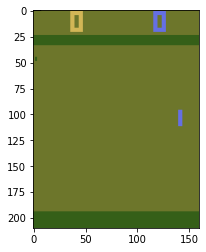

In [0]:
#Let’s take a look at the game in action.
import matplotlib.pyplot as plt
env = gym.make('Pong-v0') # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(24):
 
 if i > 22:
  plt.imshow(observation)
  plt.show()
observation, _, _, _ = env.step(1)

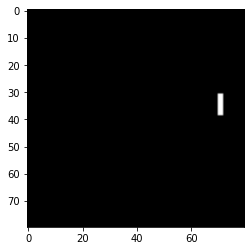

In [0]:
def prepro(I):
# Preprocess image
 I = I[35:195] # crop unesseserary parts of image
 I = I[::2,::2,0] # half pixels
 I[I == 144] = 0 # erase background (background type 1)
 I[I == 109] = 0 # erase background (background type 2)
 I[I != 0] = 1 # everything else (paddles, ball) just set to 1
 return I.astype(np.float).ravel()
#Show preprocessed
obs_preprocessed = prepro(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [0]:
def discount_rewards(r, gamma):
#  calculate reward
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0

  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset 
    running_add = running_add * gamma + r[t] 
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r

In [0]:
# import necessary modules from keras
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.models import Sequential
import keras
from keras.models import InputLayer
from keras.optimizers import Adam
# Construct model
model = Sequential()
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1280200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = []
observation = env.reset()
prev_input = None
# main training loop
while (True):
  cur_input = prepro(observation)
  x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
  prev_input = cur_input
  proba = model.predict(np.expand_dims(x, axis=1).T)
  action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
  y = 1 if action == 2 else 0
  x_train.append(x)
  y_train.append(y)
  observation, reward, done, info = env.step(action)
  rewards.append(reward)
  reward_sum += reward
  if done:
    history.append(reward_sum)
    print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
    if episode_nb>=3000 and reward_sum >=-12:
      model.save("model.h5")
      break
    else:
    # increment episode number
      episode_nb += 1
      model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
    # Reinitialization
      x_train, y_train, rewards = [],[],[]
      observation = env.reset()
      reward_sum = 0
      prev_input = None

Streaming output truncated to the last 5000 lines.
2296/2296 [==============================] - 0s 113us/step - loss: 0.0027 - accuracy: 0.9909
At the end of episode 1350 the total reward was : -21.0
Epoch 1/1
2399/2399 [==============================] - 0s 100us/step - loss: -8.2304e-04 - accuracy: 0.9879
At the end of episode 1351 the total reward was : -20.0
Epoch 1/1
1964/1964 [==============================] - 0s 102us/step - loss: -0.0034 - accuracy: 0.9913
At the end of episode 1352 the total reward was : -20.0
Epoch 1/1
2316/2316 [==============================] - 0s 105us/step - loss: 0.0124 - accuracy: 0.9892
At the end of episode 1353 the total reward was : -21.0
Epoch 1/1
1900/1900 [==============================] - 0s 102us/step - loss: 0.0017 - accuracy: 0.9847
At the end of episode 1354 the total reward was : -19.0
Epoch 1/1
2183/2183 [==============================] - 0s 104us/step - loss: 0.0020 - accuracy: 0.9885
At the end of episode 1355 the total reward was : -18.0

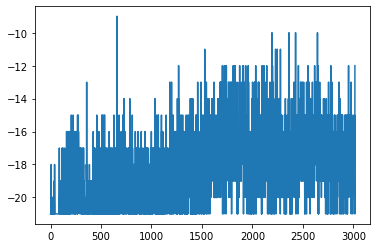

In [0]:
plt.plot(history)
plt.show()

In [0]:
model.save("model.h5")

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
# Evaluate enviroment based on trained weigths
env = wrap_env(gym.make('Pong-v0'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
while True:
  if True: 
    
    #set input to network to be difference image
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
  
    # Sample an action
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
        
    env.render()
    # Return action to environment and extract
    #next observation, reward, and status
    observation = new_observation
    new_observation, reward, done, info = env.step(action)
    if done: 
      #observation = env.reset()
      break
      
env.close()
show_video()